In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Kalman Filter Simulations

Consider a robot whose state vector tracks its position and velocity on a line. Its acceleration randomly fluctuates at each time step, and it also has a noisy position sensor. It has the following motion and measurement models:

$$\begin{align*}
    \mathbf x_k &= \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix} \mathbf x_{k-1} + \mathbf w_k \nonumber \\
    z_k &= \begin{bmatrix} 1 & 0 \end{bmatrix} \mathbf x_k + v_k, 
\end{align*}$$

where $\mathbf w_k$ and $v_k$ are distributed as zero-mean Gaussians, with covariance matrix $Q = \begin{bmatrix} 0 & 0 \\ 0 & q \end{bmatrix}$ and variance $r$, respectively. The "true" noise values are $q=1$ and $r=10$, respectively. The code below simulates the robot's movement for 50 time steps, and plots its positions and measurements over time.  

In [2]:
def move(x):
    F = np.array([[1, 1], [0, 1]])
    Q = np.array([[0, 0], [0, 1]])
    return F @ x + np.random.multivariate_normal([0,0], Q)

def measure(x):
    H = np.array([[1, 0]])
    R = 10
    return H @ x + np.random.normal(0, R)

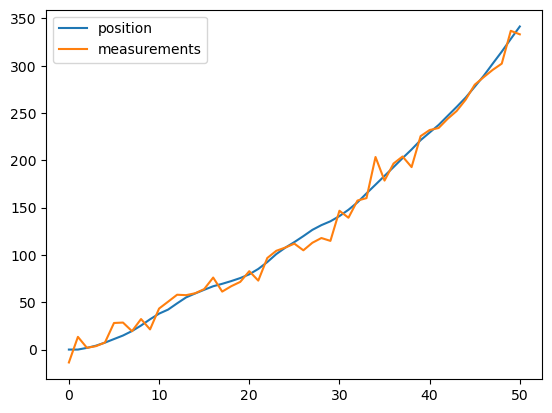

In [3]:
x = np.array([0, 0])
position = [0]
measurements = [measure(x)]

for i in range(50):
    x = move(x)
    position.append(x[0])
    measurements.append(measure(x))

plt.plot(position, label="position")
plt.plot(measurements, label="measurements")
plt.legend()
plt.show()

## Part 1

Implement a simple Kalman filter using the motion model **only** (i.e., skip the measurement update). You should not be referencing the robot simulation functions above here. Assume the initial state to be $\mathbf x_0 = (0,0)$ and $P_0$ to be a matrix of all zeros, so there is no uncertainty to begin with. Track both the position estimates $\hat x$ as well as covariance matrix $P$ over 50 steps, and generate the following:

* For $q=1$, a plot showing the two variances and one covariance values of $P$ over time (you can show them as three separate curves).

* For $q=0.01$, a plot showing the same as the above.


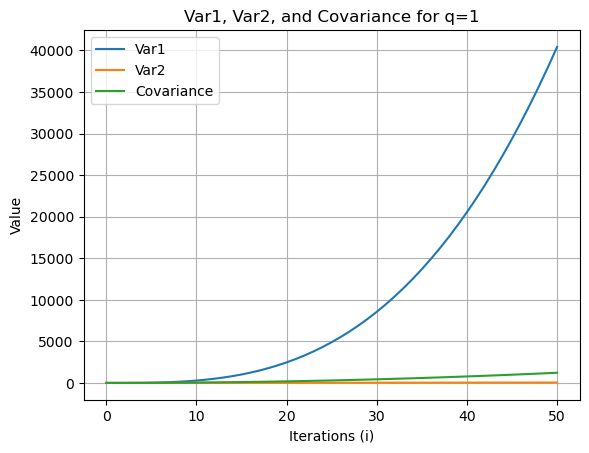

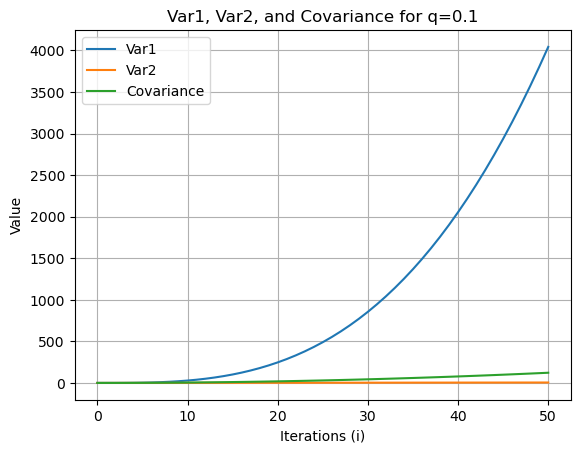

In [4]:
def predict(num_iters, q):
    x_hat = np.array([0, 0])
    P =  np.array([[0, 0], [0, 0]])
    F = np.array([[1, 1], [0, 1]])
    Q = np.array([[0, 0], [0, q]])
    var1 = [0]
    var2 = [0]
    cov = [0]
    x_vals = [x_hat]

    for i in range(num_iters):
        x_hat = F @ x_hat
        x_vals.append(x_hat)
        P = ((F @ P) @ F.T) + Q
        var1.append(P[0][0])
        var2.append(P[1][1])
        cov.append(P[0][1])
    return x_vals, var1, var2, cov

x_hat_q1, var1_q1, var2_q1, cov_q1 = predict(50, 1)
x_hat_q2, var1_q2, var2_q2, cov_q2 = predict(50, 0.1)

iterations = np.arange(0, 51)
plt.plot(iterations, var1_q1, label='Var1')
plt.plot(iterations, var2_q1, label='Var2')
plt.plot(iterations, cov_q1, label='Covariance')
plt.xlabel('Iterations (i)')
plt.ylabel('Value')
plt.title('Var1, Var2, and Covariance for q=1')
plt.legend()
plt.grid(True)
plt.show()


plt.plot(iterations, var1_q2, label='Var1')
plt.plot(iterations, var2_q2, label='Var2')
plt.plot(iterations, cov_q2, label='Covariance')
plt.xlabel('Iterations (i)')
plt.ylabel('Value')
plt.title('Var1, Var2, and Covariance for q=0.1')
plt.legend()
plt.grid(True)
plt.show()


## Part 2

Now implement the full Kalman filter. Here you will perform the estimation alongside the "true" update of the robot using the provided `move()` and `measure()` functions, so that you can incorporate the values returned by the latter into the Kalman filter. We recommend that you wrap all of your code into a function that takes in `q` and `r` as arguments, as you will be running the same experiment for different value combinations.

Track both the position estimates $\hat x$ as well as covariance matrix $P$ over 50 steps, and generate the following:

* For $q=1$ and $r=10$, a plot showing both the actual and predicted position of the robot over time.

* For the same parameter values, a plot showing the two variances and one covariance values of $P$ over time.


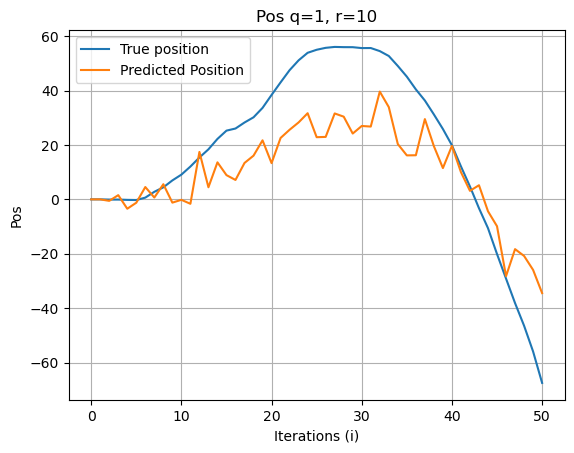

In [5]:
def KalmanFilter(x, P, z, R, F, Q, H):
    x_hat = F @ x
    P = (F @ P @ F.T) + Q
    S = (H @ P @ H.T) + R
    K = P @ (H.T @ np.linalg.inv(S))
    y = z - (H @ x_hat)
    x_hat_k = x_hat + (K @ y)
    P = (np.eye(2)-(K @ H)) @ P
    return x_hat_k, P

def runKF(q, r, num_iters): 
    P =  np.array([[0, 0], [0, 0]])
    F = np.array([[1, 1], [0, 1]])
    Q = np.array([[0, 0], [0, q]])
    H = np.array([[1, 0]])
    x = np.array([0, 0])
    true_position = [0]
    x_true = np.array([0, 0])
    pos_k = [0]
    var1_k = [0]
    var2_k = [0]
    cov_k = [0]
    for i in range(num_iters):
        x_true = move(x_true)
        z = measure(x_true)
        x_hat, P = KalmanFilter(x, P, z, r, F, Q, H)
        true_position.append(x_true[0])
        pos_k.append(x_hat[0])
        var1_k.append(P[0][0])
        var2_k.append(P[1][1])
        cov_k.append(P[0][1])
    return true_position, pos_k, var1_k, var2_k, cov_k

true_position, pos_k, var1_k, var2_k, cov_k = runKF(1, 10, 50)

def showPos(true_position, pos_k, q, r):
    plt.plot(true_position, label="True position")
    plt.plot(pos_k, label='Predicted Position')
    plt.xlabel('Iterations (i)')
    plt.ylabel('Pos')
    plt.title(f'Pos q={q}, r={r}')
    plt.legend()
    plt.grid(True)
    plt.show()

showPos(true_position, pos_k, 1, 10)

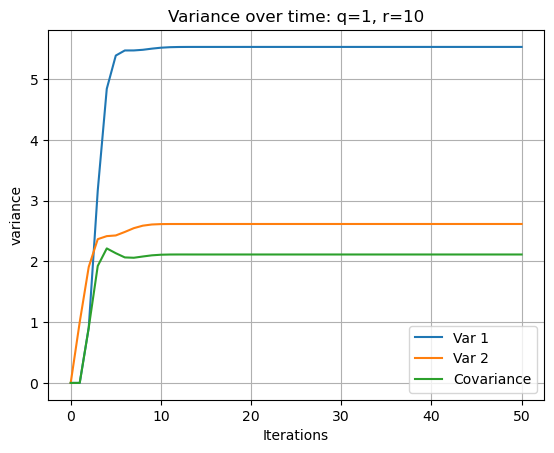

In [6]:
def showVar(var1, var2, cov, q, r): 
    plt.plot(var1_k, label="Var 1")
    plt.plot(var2_k, label='Var 2')
    plt.plot(cov_k, label="Covariance")
    plt.xlabel('Iterations')
    plt.ylabel('variance')
    plt.title(f'Variance over time: q={q}, r={r}')
    plt.legend()
    plt.grid(True)
    plt.show()

showVar(var1_k, var2_k, cov_k, 1, 10)

## Part 3

For these last couple parts, we will simply investigate the effects of under- or overestimating the uncertainty in our models. Remember that the "true" uncertainty is unchanged, as the robot behaves according to the `move()` and `measure()` functions that we provided. You should only be varying the uncertainties used by the Kalman filter.

Let's first investigate the effect of having inaccurate motion model uncertainty. Show the sets of position and (co)variance plots for the following parameter combinations and briefly explain your observations:

* $q=0.01$, $r=10$
* $q=100$, $r=10$

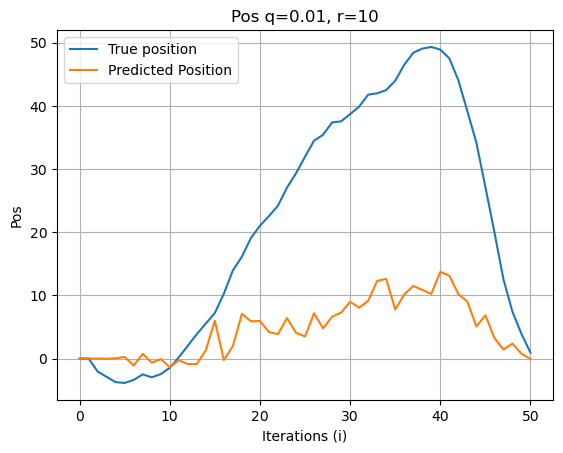

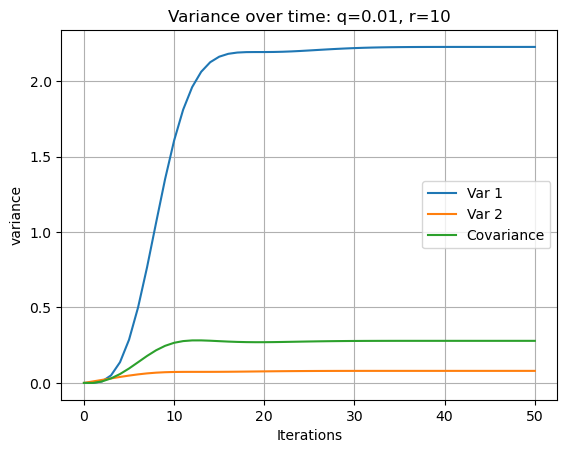

In [7]:
true_position, pos_k, var1_k, var2_k, cov_k = runKF(0.01, 10, 50)
showPos(true_position, pos_k, 0.01, 10)
showVar(var1_k, var2_k, cov_k, 0.01, 10)

When $q = 0.01$, the filter underestimates the true position. That is, the predicted positions are much less than the true positions. The variances and covariance are also lower than when $q=1$, but in this case, the covariance is greater than velocity variance.  

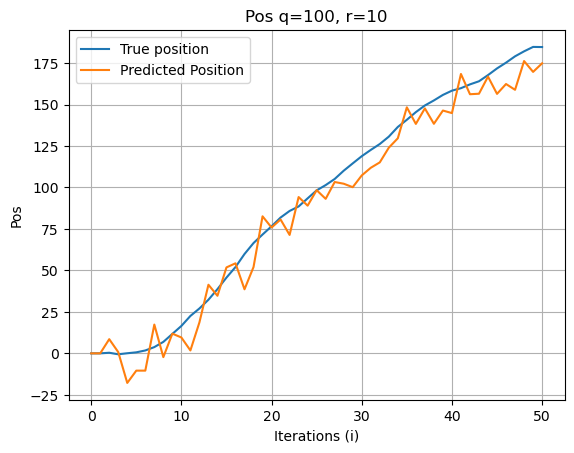

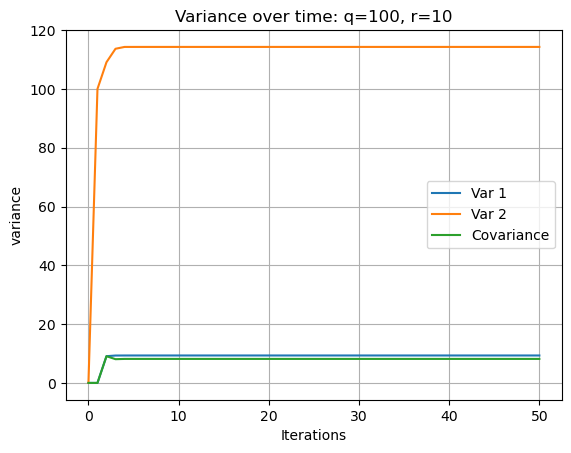

In [8]:
true_pos, pos_k, var1_k, var2_k, cov_k = runKF(100, 10, 50)
showPos(true_pos, pos_k, 100, 10)
showVar(var1_k, var2_k, cov_k, 100, 10)

When $q=100$, the predicted position curve is actually the closest to the true position curve out of all the simulations. However, the variance and covariance are much higher than the other simulations. 

## Part 4

Now let's investigate the effects of having different measurement model noise. Repeat Part 3 for the following sets of parameters, and briefly explain your observations.

* $q=1$, $r=0.1$
* $q=1$, $r=100$


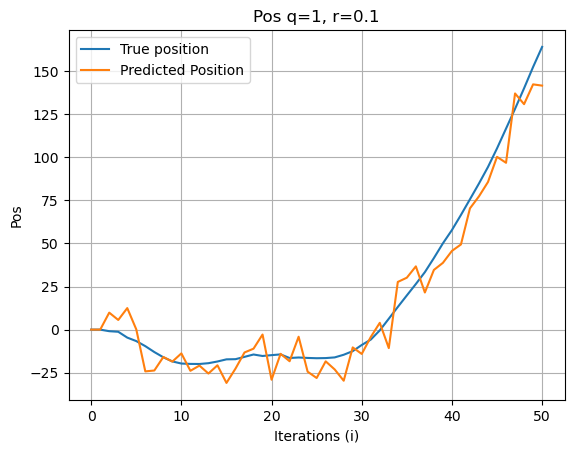

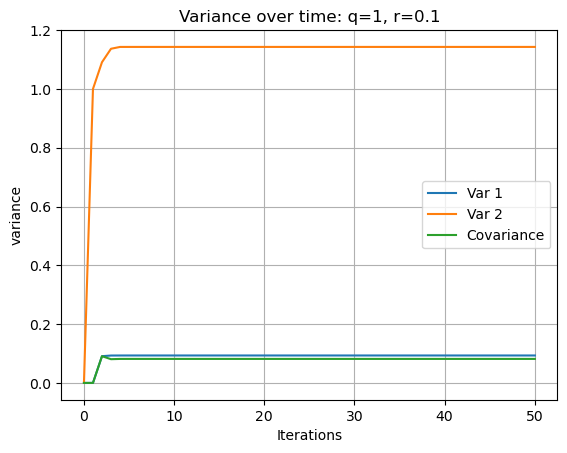

In [9]:
true_pos, pos_k, var1_k, var2_k, cov_k = runKF(1, 0.1, 50)
showPos(true_pos, pos_k, 1, 0.1)
showVar(var1_k, var2_k, cov_k, 1, 0.1)

When $q=0.1$, the predicted position is very close to the true position. However, the variance and covariance are lower than the other simulations. 

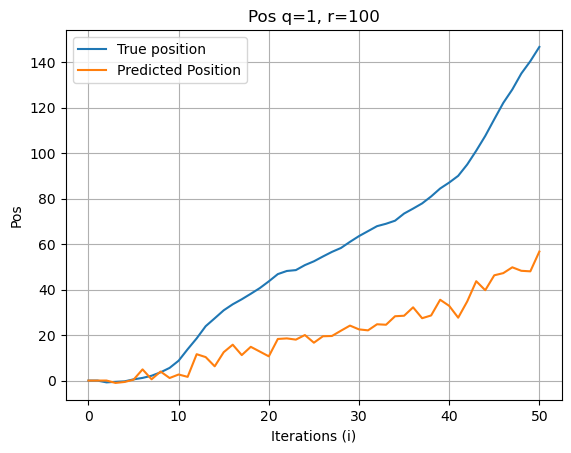

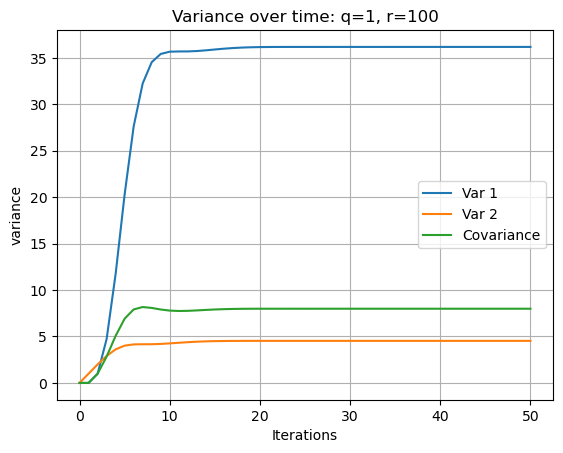

In [10]:
true_pos, pos_k, var1_k, var2_k, cov_k = runKF(1, 100, 50)
showPos(true_pos, pos_k, 1, 100)
showVar(var1_k, var2_k, cov_k, 1, 100)

When $r=100$, the predicted position curve is below the true position curve. That is, the predicted positions are less than the true positions. However, the variance (especially in position) and covariance are higher than in the other simulations. 